# CS146 Final Project
## Modeling and forecasting atmospheric CO₂ from 1958 until 2060

## Data pre-processing

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load data
url = 'https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv'
df = pd.read_csv(url, names=['date', 'ppm'], skiprows=44) # Import only relevant rows, rename accordingly

In [3]:
df.head()

,date,ppm
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


In [4]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

In [5]:
df_ttl = len(df)
df_ttl

3199

In [6]:
# Convert date to time passed (in days) 
df['days'] = (df['date'] - df['date'][0]).dt.days
# since measurements started in 1958
df['time'] = df['days'] / max(df['days'])
# Convert to years (divide by days)
df['year'] = df['days'] / 365.25

In [7]:
df.head()

,date,ppm,days,time,year
0,1958-03-29,316.19,0,0.000000,0.000000
1,1958-04-05,317.31,7,0.000306,0.019165
2,1958-04-12,317.69,14,0.000612,0.038330
3,1958-04-19,317.58,21,0.000917,0.057495
4,1958-04-26,316.48,28,0.001223,0.076660


In [8]:
df.tail()

,date,ppm,days,time,year
3194,2020-10-31,411.92,22862,0.998777,62.592745
3195,2020-11-07,412.37,22869,0.999083,62.611910
3196,2020-11-14,412.67,22876,0.999388,62.631075
3197,2020-11-21,412.98,22883,0.999694,62.650240
3198,2020-11-28,414.32,22890,1.000000,62.669405


## Modeling long-term trend in Stan

In [9]:
import pystan

In [10]:
# Define data
stan_data = {
    'data_num' : len(df),
    'time' : df['year'].values,
    'ppm' : df['ppm'].values
}

In [11]:
# Define model for general trend
# Assume quadratic long-term trend

stan_code = """

data {
  int<lower=0> data_num;
  real<lower=0> time[data_num]; 
  real<lower=0> ppm[data_num];
}

parameters {
  real<lower=0> c0;     // intercept of long-term quadratic trend
  real c1;              // coefficient of linear term in long-term quadratic trend
  real c2;              // coefficient of quadratic term in long-term quadratic trend
  real<lower=0> sigma;  
}

model {
  // Put priors over the parameters
  c0 ~ normal(280, 28); 
  c1 ~ normal(0, 12);
  c2 ~ normal(0, 4);
  sigma ~ normal(0, 4);

  for (i in 1:data_num) {
    ppm[i] ~ normal(c0 + c1*time[i] + c2*(time[i]^2), sigma);
  }
}
"""

In [12]:
# Build the model
model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c7e58b3f33d03291cbd03a5f6b3a2655 NOW.


### Results

In [13]:
import matplotlib.pyplot as plt

In [14]:
# Get the results
results = model.sampling(data=stan_data, iter=1000)

In [15]:
results

Inference for Stan model: anon_model_c7e58b3f33d03291cbd03a5f6b3a2655.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0    314.62    0.02   0.16 314.32 314.53 314.62 314.72 314.95     68    1.1
c1      0.76  1.1e-3   0.01   0.74   0.75   0.76   0.77   0.78    105   1.07
c2      0.01  1.5e-5 1.7e-4   0.01   0.01   0.01   0.01   0.01    120   1.06
sigma   2.78    0.64   0.97    2.2   2.25   2.27   3.22   4.57      2   3.48
lp__   -4427  282.65  431.8  -5242  -4589  -4195  -4193  -4192      2   3.35

Samples were drawn using NUTS at Sat Dec 19 03:40:56 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [16]:
# Obtain samples from results
samples = results.extract()

In [17]:
samples

OrderedDict([('c0',
              array([314.52104365, 314.84719394, 314.59795042, ..., 314.79667174,
                     314.61016757, 314.44622128])),
             ('c1',
              array([0.78437292, 0.75161436, 0.76974915, ..., 0.75008713, 0.76815128,
                     0.78045953])),
             ('c2',
              array([0.01272338, 0.01315536, 0.01295658, ..., 0.01324477, 0.01294537,
                     0.01281973])),
             ('sigma',
              array([4.06369449, 4.25508265, 4.19264288, ..., 2.30165403, 2.29042866,
                     2.22322918])),
             ('lp__',
              array([-4973.86328927, -5076.53149486, -5041.74066601, ...,
                     -4195.22678855, -4195.44934976, -4196.43196851]))])

In [18]:
# Derive long-term trend approximation from mean posterior samples
trend_approx = samples['c0'].mean() + samples['c1'].mean()*stan_data['time'] + samples['c2'].mean()*stan_data['time']**2

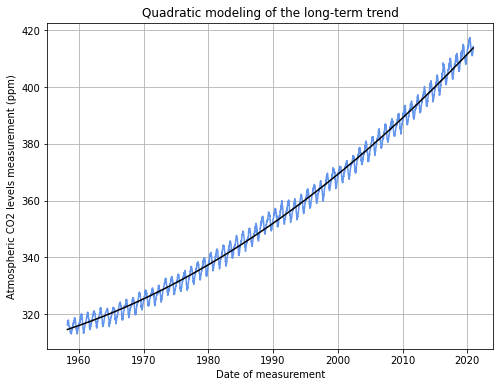

In [19]:
# Plot the trend
fig_re = plt.figure(figsize=(8,6))
plt.plot(df['date'], df['ppm'], color='cornflowerblue')
plt.plot(df['date'], trend_approx, color='black')
plt.xlabel('Date of measurement')
plt.ylabel('Atmospheric CO2 levels measurement (ppm)')
plt.title('Quadratic modeling of the long-term trend')
plt.grid()
plt.show()

In [20]:
# Calculate the residuals
residuals = df.ppm - trend_approx
df['ppm_tr_res'] = residuals
residuals

0       1.566111
1       2.671505
2       3.036890
3       2.912266
4       1.797631
          ...   
3194   -1.694952
3195   -1.290975
3196   -1.037008
3197   -0.773051
3198    0.520897
Name: ppm, Length: 3199, dtype: float64

In [21]:
# Calculate the root mean square error (RMSE)
rmse = np.sqrt(np.mean(residuals**2)) 
rmse

2.2533030373631417

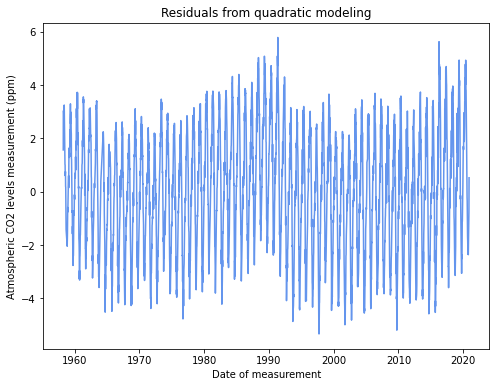

In [22]:
# Plot the uncertainty: residuals
fig_re = plt.figure(figsize=(8,6))
#plt.plot(df.date, df.ppm, color='cornflowerblue')
plt.plot(df['date'], df['ppm_tr_res'], color='cornflowerblue')
plt.xlabel('Date of measurement')
plt.ylabel('Atmospheric CO2 levels measurement (ppm)')
plt.title('Residuals from quadratic modeling')
# plt.grid()
plt.show()

## Modeling seasonal variation

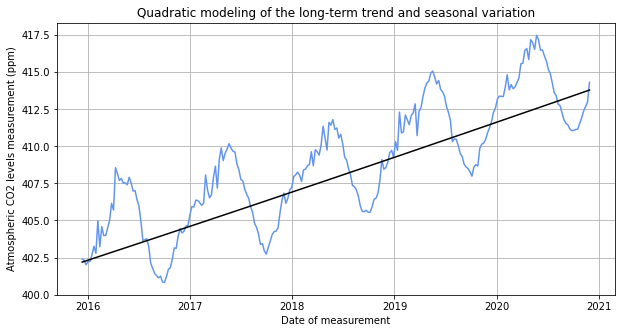

In [23]:
fig_sea = plt.figure(figsize=(10, 5))
plt.plot(df.loc[2940:, ['date']], df.loc[2940:, ['ppm']], color='cornflowerblue')
plt.plot(df.loc[2940:, ['date']], trend_approx[2940:], color='black')
plt.xlabel('Date of measurement')
plt.ylabel('Atmospheric CO2 levels measurement (ppm)')
plt.title('Quadratic modeling of the long-term trend and seasonal variation')
plt.grid()
plt.show()

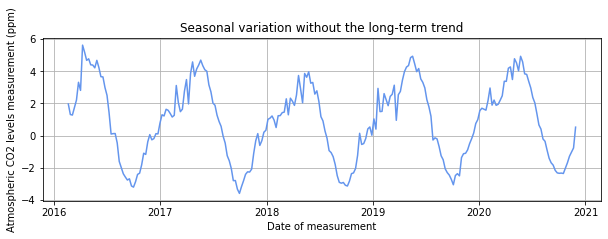

In [24]:
fig_sea = plt.figure(figsize=(10, 3))
plt.plot(df.loc[2950:, ['date']], df.loc[2950:, ['ppm_tr_res']], color='cornflowerblue')
plt.xlabel('Date of measurement')
plt.ylabel('Atmospheric CO2 levels measurement (ppm)')
plt.title('Seasonal variation without the long-term trend')
plt.grid()
plt.show()

In [25]:
# Define data
stan_data_s = {
    'data_num' : len(df),
    'time' : df['year'].values,
    'ppm' : df['ppm_tr_res'].values,
    'period' : 2*np.pi  # define period as 2pi: working with trigonometric functions
}

In [26]:
# Define model for seasonal variation
# Assume double negative sine

stan_code_s = """

data {
  int<lower=0> data_num;
  real<lower=0> time[data_num]; 
  real ppm[data_num];
  real<lower=0> period;
}

parameters {
  real<lower=0> c3;    // amplitude
  real c4_x;
  real c4_y;
  real<lower=0> sigma;
}

transformed parameters {    // use phase shift because periodic
  real<lower=0, upper=1> c4 = atan2(c4_x, c4_y)/period;
}

model {
  // Put priors over the parameters
  c3 ~ normal(4, 2);
  c4_x ~ normal(0, 1);
  c4_y ~ normal(0, 1);
  sigma ~ gamma(2, 1);

  for (i in 1:data_num) {
      ppm[i] ~ normal(c3*sin(period*time[i]+c4+0.5), sigma); 
  }
}
"""

In [27]:
# Build model
model_s = pystan.StanModel(model_code=stan_code_s)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5a7ea5cc411dcb9aec95a507ed0a20a5 NOW.


### Results

In [28]:
# Get the results
results_s = model_s.sampling(data=stan_data_s, iter=1000)
results_s

Inference for Stan model: anon_model_5a7ea5cc411dcb9aec95a507ed0a20a5.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c3      2.82  2.2e-3   0.02   2.77   2.81   2.82   2.84   2.87    127   1.01
c4_x  5.2e-3  1.7e-3 6.6e-3 7.2e-5 7.8e-4 2.6e-3 7.4e-3   0.02     15   1.13
c4_y   -1.45    0.55   0.83  -2.64  -2.22   -1.5  -0.49  -0.26      2   3.42
sigma   1.04  1.2e-3   0.01   1.02   1.04   1.04   1.05   1.07    113   1.02
c4       0.5  3.6e-5 5.2e-4    0.5    0.5    0.5    0.5    0.5    207   1.01
lp__   -1739    0.87    1.9  -1743  -1740  -1739  -1738  -1736      5   1.37

Samples were drawn using NUTS at Sat Dec 19 03:42:19 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [29]:
# Obtain samples from results
samples_s = results_s.extract()

In [30]:
samples_s

OrderedDict([('c3',
              array([2.82464529, 2.82104698, 2.83366492, ..., 2.79630822, 2.76552792,
                     2.8129393 ])),
             ('c4_x',
              array([0.01453312, 0.00122267, 0.00193243, ..., 0.02709273, 0.00342972,
                     0.02099414])),
             ('c4_y',
              array([-1.39221461, -1.24428922, -1.15595773, ..., -2.24095421,
                     -2.16950991, -2.2793043 ])),
             ('sigma',
              array([1.02501478, 1.06620923, 1.06715616, ..., 1.0729062 , 1.06314493,
                     1.04607451])),
             ('c4',
              array([0.49833867, 0.49984361, 0.49973394, ..., 0.49807594, 0.4997484 ,
                     0.4985341 ])),
             ('lp__',
              array([-1741.55263993, -1738.78087034, -1739.09557794, ...,
                     -1744.97992764, -1742.38262526, -1741.66941719]))])

In [31]:
# Derive seasonality approximation from mean posterior samples
sea_approx = samples_s['c3'].mean()*np.sin(2*np.pi*(stan_data_s['time'] + samples_s['c4'].mean()))

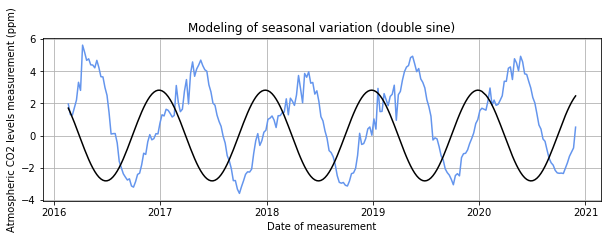

In [32]:
# Plot the seasonal variation -- excludes trend
fig_sea_s = plt.figure(figsize=[10,3])
plt.plot(df.loc[2950:, ['date']], df.loc[2950:, ['ppm_tr_res']], color='cornflowerblue')
plt.plot(df.loc[2950:, ['date']], sea_approx[2950:], color='black')
plt.xlabel('Date of measurement')
plt.ylabel('Atmospheric CO2 levels measurement (ppm)')
plt.title("Modeling of seasonal variation (double sine)")
plt.grid()
plt.show()

In [33]:
# Calculate the residuals
residuals_s = df['ppm_tr_res'] - sea_approx
df['ppm_s_res'] = residuals_s
residuals_s

0       1.556519
1       3.001194
2       3.701086
3       3.901348
4       3.097276
          ...   
3194   -3.240898
3195   -3.109590
3196   -3.101952
3197   -3.054419
3198   -1.943854
Name: ppm_tr_res, Length: 3199, dtype: float64

In [34]:
# Calculate the root mean square error (RMSE)
rmse_s = np.sqrt(np.mean(residuals_s**2)) 
rmse_s

3.511998491121321

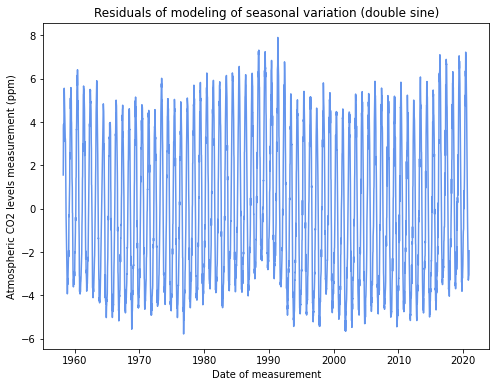

In [35]:
# Plot the uncertainty: residuals
fig_re_s = plt.figure(figsize=(8,6))
plt.plot(df.date, residuals_s, color='cornflowerblue')
# plt.plot(df.date, residuals, color='red')
plt.xlabel('Date of measurement')
plt.ylabel('Atmospheric CO2 levels measurement (ppm)')
plt.title('Residuals of modeling of seasonal variation (double sine)')
# plt.grid()
plt.show()

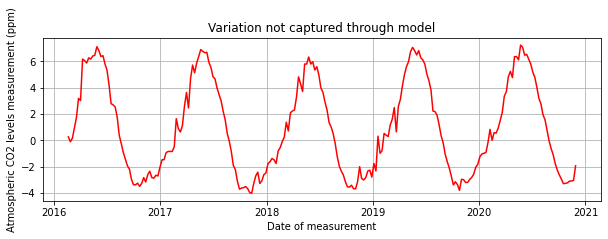

In [36]:
# Plot variation not captured
fig_res = plt.figure(figsize=(10, 3))
plt.plot(df.loc[2950:, ['date']], df.loc[2950:, ['ppm_s_res']], color='red')
plt.xlabel('Date of measurement')
plt.ylabel('Atmospheric CO2 levels measurement (ppm)')
plt.title('Variation not captured through model')
plt.grid()
plt.show()

##Forecasting



In [37]:
# Get coefficients from approximate posterior distributions over all model parameters
samples_tr_coef = np.array(list(map(list, zip(*samples.values()))))[:2000, :3]
samples_sea_coef = list(map(list, zip(*samples_s.values())))
samples_sea_coef = np.array([sample[:2] + sample[3:5] for sample in samples_sea_coef]) # Ignore the posterior samples of the phase helpers

### Likelihood

In [38]:
def likelihood(t, trend_coef, seasonal_coef):
    c0, c1, c2 = trend_coef
    c3, c5, sigma, c4 = seasonal_coef
    return(np.array(sts.norm.rvs(c0 + c1*t + c2*t**2 + c3*np.sin(2*np.pi*t+c4) + sigma))) 

### Predict

In [39]:
import scipy.stats as sts

In [40]:
# Define time period for prediction
pred_date = pd.date_range('2021-01-01', '2059-12-30', freq='W-FRI')
pred_time = (pred_date - pd.to_datetime(df['date'][0])).days / 365.25

In [41]:
# Predict using likelihood
y_pred = np.array([likelihood(pred_time, trend_coef, seasonal_coef) for trend_coef, seasonal_coef in zip(samples_tr_coef, samples_sea_coef)])

In [42]:
# Calculate mean and confidence of the predictions
pred_mean = y_pred.mean(axis=0)
conf_int = np.percentile(y_pred, axis=0, q=[2.5, 97.5])
print(conf_int[0].mean())
print(conf_int[1].mean())

466.4226886016023
470.7381209595989


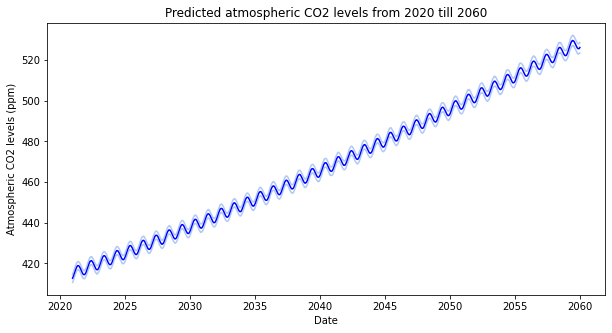

In [43]:
# Plot predictions
fig_pred = plt.figure(figsize=(10,5))
plt.title('Predicted atmospheric CO2 levels from 2020 till 2060')
plt.xlabel('Date')
plt.ylabel('Atmospheric CO2 levels (ppm)')
plt.plot(pred_date, pred_mean, color='blue')
plt.plot(pred_date, conf_int[0], color='cornflowerblue', alpha=0.5)
plt.plot(pred_date, conf_int[1], color='cornflowerblue', alpha=0.5)
plt.show()

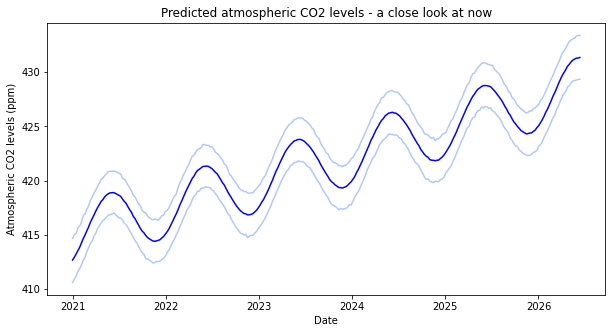

In [44]:
# Zoom in on figure
fig_pred_zoom = plt.figure(figsize=(10,5))
plt.title('Predicted atmospheric CO2 levels - a close look at now')
plt.xlabel('Date')
plt.ylabel('Atmospheric CO2 levels (ppm)')
plt.plot(pred_date[:-1750], pred_mean[:-1750], color='blue')
plt.plot(pred_date[:-1750], conf_int[0][:-1750], color='cornflowerblue', alpha=0.5)
plt.plot(pred_date[:-1750], conf_int[1][:-1750], color='cornflowerblue', alpha=0.5)
plt.show()

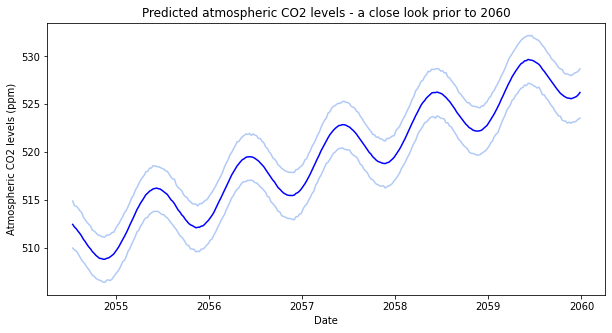

In [45]:
# Zoom in on figure
fig_pred_zoom = plt.figure(figsize=(10,5))
plt.title('Predicted atmospheric CO2 levels - a close look prior to 2060')
plt.xlabel('Date')
plt.ylabel('Atmospheric CO2 levels (ppm)')
plt.plot(pred_date[1750:], pred_mean[1750:], color='blue')
plt.plot(pred_date[1750:], conf_int[0][1750:], color='cornflowerblue', alpha=0.5)
plt.plot(pred_date[1750:], conf_int[1][1750:], color='cornflowerblue', alpha=0.5)
plt.show()

In [46]:
# Find index when 450ppm (high-risk level) is surpassed with high confidence
past_450 = np.min(np.argwhere(conf_int[0] > 450)) # Find first CI with level above 450
past_450

696

In [47]:
# Find C02 level of 2060
pred_mean[-1]

526.2305478862047

In [48]:
# Find corresponding date
worry_date = pred_date[past_450]
worry_date

Timestamp('2034-05-05 00:00:00', freq='W-FRI')

## Evaluate model

In [49]:
# Generate prediction samples of data
y_pred_s = np.array([likelihood(df['year'].values, trend_coef, seasonal_coef) for trend_coef, seasonal_coef in zip(samples_tr_coef, samples_sea_coef)])

In [54]:
# Mean error
diff = np.mean(y_pred_s - df['ppm'].values, axis=1)
exp_val = 0
mean_error = np.mean(diff < exp_val)

Text(0.5, 1.0, 'Mean error p-value:  1.0')

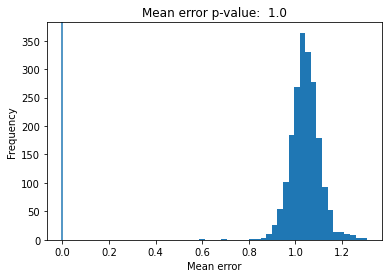

In [53]:
# Plot histogram of mean error 
plt.hist(diff, bins=30)
plt.axvline(exp_val)
plt.ylabel('Frequency')
plt.xlabel('Mean error')
plt.title(f'Mean error p-value:  {mean_error}')